# Milestone Project 1: Food Vision Big
This project is done on colab since the dataset filesize is quite big (5 gb)

Links (to compare to your model at the end):
- [fine_tuned_mixed_precision_efficientnet_model](https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip)

### Check the Colab GPU and ensure it is a Tesla T4, in order to use mixed precision training

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-eaa6cfc8-4a81-2cb6-8ca8-239c5631fe10)


In [2]:
# Import the helper function
# No need if it is already in your folder
!wget https://raw.githubusercontent.com/EngMarchG/TensorFlow-Mastery/master/helper/helperFunctions.py

--2022-05-08 14:59:47--  https://raw.githubusercontent.com/EngMarchG/TensorFlow-Mastery/master/helper/helperFunctions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11679 (11K) [text/plain]
Saving to: ‘helperFunctions.py’

helperFunctions.py  100%[===================>]  11.41K  --.-KB/s    in 0s      

2022-05-08 14:59:47 (78.9 MB/s) - ‘helperFunctions.py’ saved [11679/11679]



In [3]:
# Import a few functionalities of the module
# import sys
# sys.path.append("./../helper/")
from helperFunctions import create_tensorboard_callback, plot_loss_curves, compare_historys

# Use TensorFlow Datasets to Download Data

In [4]:
# import TensorFlow Datasets
import tensorflow_datasets as tfds 

In [5]:
# List all available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # Checking if the target dataset is in the list

True


In [6]:
# Load in the data
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # Data gets returned as tuple (data, label)
                                             with_info=True) # Downloads ds_info aka meta data

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteQ0M2VM/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteQ0M2VM/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the Food101 Data from Tensorflow DataSet

To become one with the data, find:
- Class names
- The shape of input data
The datatype of our input data
- What the labels look like (one-hot encoded or strings)
- Do the labels match up with the image

In [7]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [8]:
# Get the class name
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [9]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # Samples are in format (image_tensor, label)
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [10]:
# Output info about the training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]} """)


  Image shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 16
  Class name (str form): cheesecake 


In [11]:
# What does the image tensor from TFDS Food101 look like?
# Taking another sample the shapes are of different resolutions and unscaled
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 85,  84,  92],
        [ 86,  85,  93],
        [ 93,  92, 100],
        ...,
        [120, 196, 245],
        [120, 198, 246],
        [121, 199, 247]],

       [[ 88,  88,  96],
        [ 82,  82,  90],
        [ 88,  88,  96],
        ...,
        [116, 192, 244],
        [118, 195, 249],
        [119, 196, 248]],

       [[ 77,  80,  89],
        [ 75,  78,  87],
        [ 82,  86,  95],
        ...,
        [115, 189, 252],
        [117, 192, 255],
        [118, 194, 255]],

       ...,

       [[159, 166, 194],
        [154, 161, 187],
        [171, 178, 204],
        ...,
        [219, 216, 235],
        [223, 220, 239],
        [227, 226, 244]],

       [[170, 179, 208],
        [169, 179, 206],
        [173, 183, 210],
        ...,
        [218, 217, 235],
        [223, 222, 240],
        [226, 227, 245]],

       [[168, 177, 206],
        [170, 179, 208],
        [152, 162, 189],
        ...,
        [224, 223, 24

In [12]:
# What are the min and max values of the image tensor?
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

Plot an image from the Dataset

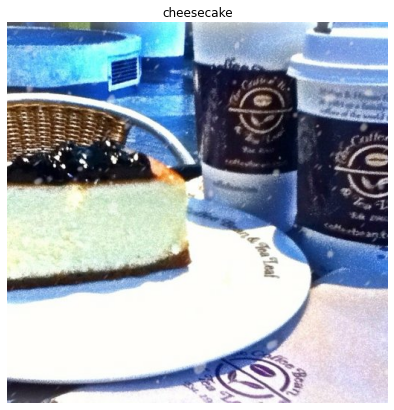

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.title(class_names[label.numpy()])
plt.axis(False)
plt.imshow(image)

# Create preprocessing Functions for the data
How the data currently is:
- Type: 'uint8' datatyp
- Comprised of different sized tensors
- Unscaled

What do models prefer:
- Data in 'float32' dtype or mixed precision type 'float16 and float32'
- Batch sizes need to be of the same image size
- Scaled images (0 & 1)

Rescaling won't be necessary in this case since EfficientNetBX will be used

In [14]:
# Make a function for preprocessing image
def preprocessing_img(image, label, img_shape=224, scaler=False):
  """
  Converts image datatypes to 'float32' and reshapes
  image to [img_shape, img_shape, colour_channels]
  scaler (Bool): scales the iamge if necessary (default false)
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape target image
  if scaler:
    image = image/255
  return tf.cast(image, tf.float32), label # returns (float32_image, label)

In [15]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocessing_img(image, label)[0]
print(f"Image before preprocessing: \n {image[:2]}...m nShape: {image.shape}, \nDatatype: {image.dtype}\n")
print(f"Image before preprocessing: \n {preprocessed_img[:2]}...m nShape: {preprocessed_img.shape}, \nDatatype: {preprocessed_img.dtype}")

Image before preprocessing: 
 [[[ 85  84  92]
  [ 86  85  93]
  [ 93  92 100]
  ...
  [120 196 245]
  [120 198 246]
  [121 199 247]]

 [[ 88  88  96]
  [ 82  82  90]
  [ 88  88  96]
  ...
  [116 192 244]
  [118 195 249]
  [119 196 248]]]...m nShape: (512, 512, 3), 
Datatype: <dtype: 'uint8'>

Image before preprocessing: 
 [[[ 84.67857   84.321434  92.321434]
  [ 87.19898   86.841835  94.841835]
  [ 84.72959   84.581635  94.72449 ]
  ...
  [119.50503  194.93877  245.85202 ]
  [114.974525 190.97452  241.90309 ]
  [119.071465 196.4286   247.82652 ]]

 [[ 75.647964  84.21939   93.21939 ]
  [ 71.45407   80.959175  89.959175]
  [ 78.03061   87.20408   97.47449 ]
  ...
  [113.31632  182.62755  249.35715 ]
  [106.57655  176.86227  245.4337  ]
  [108.601944 179.9796   248.16833 ]]]...m nShape: (224, 224, 3), 
Datatype: <dtype: 'float32'>


## Prepare batches 
Data input pipelines are recommended to run really fast
Extra resources: www.tensorflow.org/guide

In [16]:
# Map preprocessing function to training and (parallelize)
train_data = train_data.map(map_func=preprocessing_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE) # Stores data in memory for faster batching

# Map preprocessing function to test data
test_data = test_data.map(preprocessing_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE) # .cache if needed

In [17]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

Maps the preprocessing function ('preprocess_img') across the training dataset, then shuffle a number of elements and batch them together. Finally, prepare new patches (prefetch), while the model is looking through (finding patterns) in the current batch.

## Create modelling callbacks

Create a couple of callbacks to help out while the model trains
- TensorBoard Callback to log training results (so it can be visalized later if needed)
- ModelCheckPoint callback to save the model's progress after feature extraction

In [18]:
# Create a tensorboard callback (premade function will be imported)
from helperFunctions import create_tensorboard_callback

# Create ModelCheckpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoint"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc", # others like val_loss
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0) # 0 doesn't print 1 prints 2 prints more stuff


## Setup mixed precision training
To understand the process read the following link: [Precision training](www.tensorflow.org/guide/mixed_precision)

In [19]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # Set global policy to mixed precision

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [20]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Building the feature extracting model

In [21]:
from tensorflow.keras import layers

In [22]:
# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create Functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# x = preprocessing.Rescaling(1/255)(x)  # if rescaling was necessary
x = base_model(inputs, training=False) 
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
# Only change is the activation outside to pass types
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16719872/16705208 [==============================] - 0s 0us/step


In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

### Checking layer dtype policies (to check if mixed precision is being used)

In [24]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


As seen above:
- layer.name: the name of the particular layer
- layer.trainable: is the layer trainable or not
- layer.dtype: the datatype a layer stores its variables in
- layer.dtype_policy: the datatype a layer computes its variables with

This layer type remains float32 to maintain stability

In [25]:
for layer in model.layers[1].layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False flo

In [26]:
# The model is successfully using mixed precision
mixed_precision.global_policy()

<Policy "mixed_float16">

In [27]:
# Fit the model
history_101_food_classes_feature_extract = model.fit(train_data,
                                              epochs=3,
                                              steps_per_epoch=len(train_data),
                                              validation_data=test_data,
                                              validation_steps=int(0.15*len(test_data)),
                                              callbacks=[create_tensorboard_callback(
                                                  dir_name="training_logs",
                                                  experiment_name="efficientnetb0_101_classes_all_data_feature_extract"),
                                                  model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20220508-150732
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.8208 - accuracy: 0.5565WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 186s 71ms/step - loss: 1.8208 - accuracy: 0.5565 - val_loss: 1.2304 - val_accuracy: 0.6777
Epoch 2/3
2368/2368 [==============================] - ETA: 0s - loss: 1.2929 - accuracy: 0.6657WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 170s 71ms/step - loss: 1.2929 - accuracy: 0.6657 - val_loss: 1.1255 - val_accuracy: 0.7005
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.1429 - accuracy: 0.7021WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 163s 68ms/step - loss: 1.1429 - accuracy: 0.7021 - val_loss: 1.0856 - val_accuracy: 0.7042


In [28]:
# Evaluate the model
model.evaluate(test_data)

790/790 [==============================] - 49s 62ms/step - loss: 1.0943 - accuracy: 0.7053


[1.0942679643630981, 0.7053465247154236]

In [ ]:
# Save the model for later use
model.save("model_baseline_101_foods_all_data")

In [ ]:
# Colab commands to download the model
# The first part names the zip and the 2nd is the folder to be ziped
!zip -r /content/model.zip /content/model_baseline_101_foods_all_data

In [ ]:
# Download the file 
from google.colab import files
files.download("/content/model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# It is time to fine-tune the model and beat the baseline

In [30]:
# First rebuild the mode with data augmentation
from tensorflow.keras import Sequential
data_augmentation = Sequential([
                                layers.RandomFlip("horizontal"),
                                layers.RandomZoom(0.2),
                                layers.RandomWidth(0.2),
                                layers.RandomHeight(0.2),
                                layers.RandomRotation(0.2)
], name="data_agumentation")

In [31]:
# Create base model
input_shape = (224, 224, 3)
base_model_augmented = tf.keras.applications.EfficientNetB0(include_top=False)
base_model_augmented.trainable = False

# Create Functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# x = preprocessing.Rescaling(1/255)(x)  # if rescaling was necessary
x = data_augmentation(inputs) 
x = base_model_augmented(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
# Only change is the activation outside to pass types
base_model_augmented = tf.keras.Model(inputs, outputs)

# Compile the model
base_model_augmented.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [32]:
# Fit the model 
history_2_101_foods_all_augmented = base_model_augmented.fit(train_data,
                                                            epochs=3,
                                                            steps_per_epoch=len(train_data),
                                                            validation_data=test_data,
                                                            validation_steps=int(0.15*len(test_data)),
                                                            callbacks=[create_tensorboard_callback("training_log_aug",
                                                                                                   "efficientnetb0_101_classes_all_data_augmented"),
                                                                                                    model_checkpoint])

Saving TensorBoard log files to: training_log_aug/efficientnetb0_101_classes_all_data_augmented/20220508-151816
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 2.2450 - accuracy: 0.4597WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 198s 80ms/step - loss: 2.2450 - accuracy: 0.4597 - val_loss: 1.4029 - val_accuracy: 0.6255
Epoch 2/3
2368/2368 [==============================] - ETA: 0s - loss: 1.7562 - accuracy: 0.5572WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 178s 74ms/step - loss: 1.7562 - accuracy: 0.5572 - val_loss: 1.2928 - val_accuracy: 0.6568
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.6442 - accuracy: 0.5805WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 174s 73ms/step - loss: 1.6442 - accuracy: 0.5805 - val_loss: 1.2450 - val_accuracy: 0.6610


In [33]:
evaluated_base_aug = base_model_augmented.evaluate(test_data)
evaluated_base_aug

790/790 [==============================] - 48s 61ms/step - loss: 1.2640 - accuracy: 0.6589


[1.2640385627746582, 0.6588910818099976]

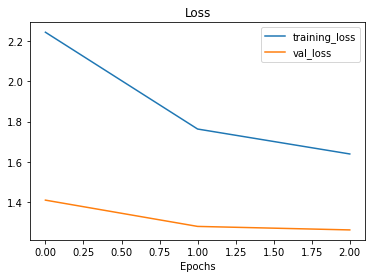

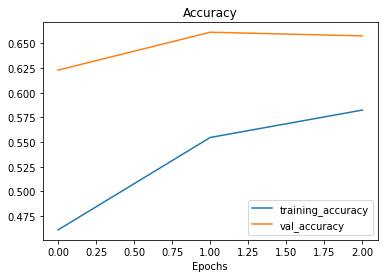

In [ ]:
plot_loss_curves(history_2_101_foods_all_augmented)

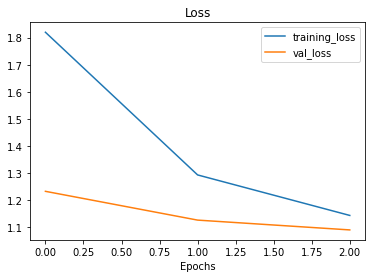

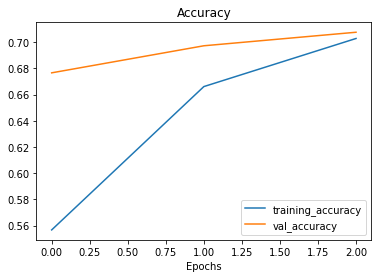

In [ ]:
plot_loss_curves(history_101_food_classes_feature_extract)

It seems that the model is starting to overfit in the data augmented model.
Save the model and fine-tune it with 5 unfrozen layers

## Fine-Tuning the model

In [34]:
# Save the new augmented model 
base_model_augmented.save("model_101_foods_augmented_model")

INFO:tensorflow:Assets written to: model_101_foods_augmented_model/assets


INFO:tensorflow:Assets written to: model_101_foods_augmented_model/assets


In [35]:
# Load the augmented model
base_model_augmented = tf.keras.models.load_model("model_101_foods_augmented_model")

In [36]:
# Unfreeze the last 5 layers
base_model_augmented.trainable = True

for layer in base_model_augmented.layers[2].layers[:-5]:
  layer.trainable = False

In [37]:
for layer in base_model_augmented.layers[2].layers:
  print(layer.name, layer.trainable)

input_2 False
rescaling_1 False
normalization_1 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_project_conv False

In [38]:
# Fine-tune for another 3 epochs
fine_tine_epochs = 6

# Recompile the model
base_model_augmented.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

# Fit the model
history_3_101_foods_all_augmented = base_model_augmented.fit(train_data,
                                                             epochs=fine_tine_epochs,
                                                             validation_data=test_data,
                                                             validation_steps=int(0.15*len(test_data)),
                                                             callbacks=[create_tensorboard_callback(
                                                                 "training_log_aug",
                                                                 "efficientnetb0_101_classes_all_data_augmented_fine_tuned"
                                                             )],
                                                             initial_epoch=history_2_101_foods_all_augmented.epoch[-1])


Saving TensorBoard log files to: training_log_aug/efficientnetb0_101_classes_all_data_augmented_fine_tuned/20220508-153022
Epoch 3/6
2368/2368 [==============================] - 183s 74ms/step - loss: 1.4735 - accuracy: 0.6193 - val_loss: 1.1453 - val_accuracy: 0.6894
Epoch 4/6
2368/2368 [==============================] - 178s 74ms/step - loss: 1.3546 - accuracy: 0.6458 - val_loss: 1.1027 - val_accuracy: 0.7034
Epoch 5/6
2368/2368 [==============================] - 176s 74ms/step - loss: 1.2812 - accuracy: 0.6622 - val_loss: 1.0834 - val_accuracy: 0.7068
Epoch 6/6
2368/2368 [==============================] - 171s 71ms/step - loss: 1.2304 - accuracy: 0.6754 - val_loss: 1.0627 - val_accuracy: 0.7079


In [39]:
# Evaluate the augmented and fine-tuned model over the whole test set
base_model_augmented.evaluate(test_data)

790/790 [==============================] - 49s 62ms/step - loss: 1.0812 - accuracy: 0.7062


[1.0812370777130127, 0.7061781883239746]

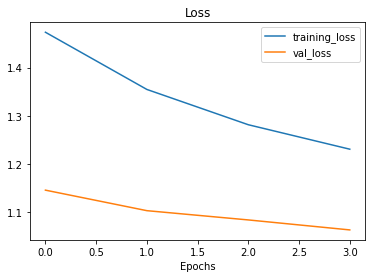

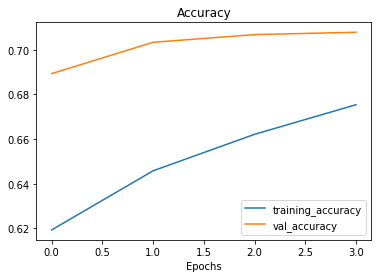

In [40]:
# Plot the loss curves of the new history
# The model trend appears to be much better than last time!
plot_loss_curves(history_3_101_foods_all_augmented)

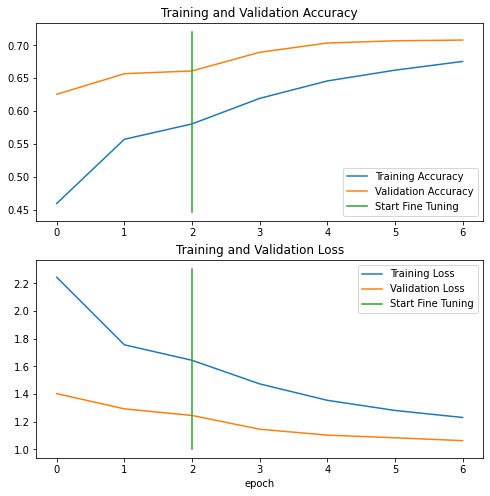

In [41]:
compare_historys(history_2_101_foods_all_augmented, history_3_101_foods_all_augmented, initial_epochs=3)

Comparing the history of the new model with the old non-trainable one, it can be seen that the model stops improving as much at around 5 epochs.

In [42]:
# How about unfreezing 2 more layers and increasing the epochs by 1

In [43]:
model_4_aug_fine_tuned = tf.keras.models.load_model("model_101_foods_augmented_model")

In [44]:
# Unfreeze the last 7 layers
model_4_aug_fine_tuned.trainable = True

for layer in model_4_aug_fine_tuned.layers[2].layers[:-7]:
  layer.trainable = False

In [45]:
# Fine-tune for another 4 epochs
fine_tine_epochs = 7

# Recompile the model
model_4_aug_fine_tuned.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

# Fit the model
history_4_101_foods_all_augmented = model_4_aug_fine_tuned.fit(train_data,
                                                             epochs=fine_tine_epochs,
                                                             validation_data=test_data,
                                                             validation_steps=int(0.15*len(test_data)),
                                                             callbacks=[create_tensorboard_callback(
                                                                 "training_log_aug",
                                                                 "efficientnetb0_101_classes_all_data_augmented_fine_tuned_7Layers"
                                                             )],
                                                             initial_epoch=history_2_101_foods_all_augmented.epoch[-1])


Saving TensorBoard log files to: training_log_aug/efficientnetb0_101_classes_all_data_augmented_fine_tuned_7Layers/20220508-154436
Epoch 3/7
2368/2368 [==============================] - 183s 74ms/step - loss: 1.4637 - accuracy: 0.6222 - val_loss: 1.1267 - val_accuracy: 0.7005
Epoch 4/7
2368/2368 [==============================] - 177s 74ms/step - loss: 1.3454 - accuracy: 0.6490 - val_loss: 1.0874 - val_accuracy: 0.7084
Epoch 5/7
2368/2368 [==============================] - 170s 71ms/step - loss: 1.2665 - accuracy: 0.6661 - val_loss: 1.0543 - val_accuracy: 0.7177
Epoch 6/7
2368/2368 [==============================] - 174s 73ms/step - loss: 1.2042 - accuracy: 0.6804 - val_loss: 1.0375 - val_accuracy: 0.7142
Epoch 7/7
2368/2368 [==============================] - 176s 73ms/step - loss: 1.1578 - accuracy: 0.6936 - val_loss: 1.0233 - val_accuracy: 0.7206


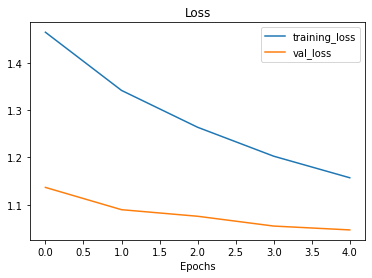

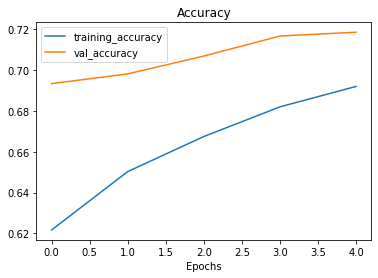

In [ ]:
# The last epochs seems to barely make a dent but the over all trend apepear 
# to be good
plot_loss_curves(history_4_101_foods_all_augmented)

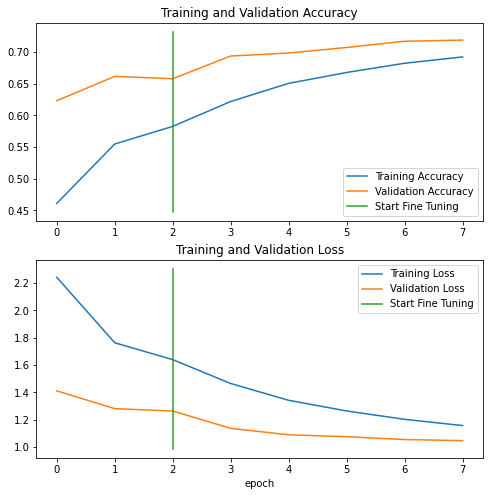

In [ ]:
compare_historys(history_2_101_foods_all_augmented,history_4_101_foods_all_augmented, initial_epochs=3)

In [46]:
# Save the model
model_4_aug_fine_tuned.save("model_101_foods_augmented_model_7t_Layers")

INFO:tensorflow:Assets written to: model_101_foods_augmented_model_7t_Layers/assets


INFO:tensorflow:Assets written to: model_101_foods_augmented_model_7t_Layers/assets


In [ ]:
# Colab commands to download the model
!zip -r /content/model_tuned.zip /content/model_101_foods_augmented_model_7t_Layers

# Download the file 
from google.colab import files
files.download("/content/model_tuned.zip")

  adding: content/model_101_foods_augmented_model_7t_Layers/ (stored 0%)
  adding: content/model_101_foods_augmented_model_7t_Layers/assets/ (stored 0%)
  adding: content/model_101_foods_augmented_model_7t_Layers/saved_model.pb (deflated 91%)
  adding: content/model_101_foods_augmented_model_7t_Layers/variables/ (stored 0%)
  adding: content/model_101_foods_augmented_model_7t_Layers/variables/variables.index (deflated 74%)
  adding: content/model_101_foods_augmented_model_7t_Layers/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/model_101_foods_augmented_model_7t_Layers/keras_metadata.pb (deflated 96%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [47]:
# Final model with 10 layers and 8 epochs
model_5_aug_fine_tuned = tf.keras.models.load_model("model_101_foods_augmented_model")

In [48]:
# Unfreeze the last 10 layers
model_5_aug_fine_tuned.trainable = True

for layer in model_5_aug_fine_tuned.layers[2].layers[:-10]:
  layer.trainable = False

In [49]:
# Fine-tune for another 5 epochs
fine_tine_epochs = 8

# Recompile the model
model_5_aug_fine_tuned.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

# Fit the model
history_5_101_foods_all_augmented = model_5_aug_fine_tuned.fit(train_data,
                                                             epochs=fine_tine_epochs,
                                                             validation_data=test_data,
                                                             validation_steps=int(0.15*len(test_data)),
                                                             callbacks=[create_tensorboard_callback(
                                                                 "training_log_aug",
                                                                 "efficientnetb0_101_classes_all_data_augmented_fine_tuned_10Layers"
                                                             )],
                                                             initial_epoch=history_2_101_foods_all_augmented.epoch[-1])


Saving TensorBoard log files to: training_log_aug/efficientnetb0_101_classes_all_data_augmented_fine_tuned_10Layers/20220508-160141
Epoch 3/8
2368/2368 [==============================] - 184s 74ms/step - loss: 1.4544 - accuracy: 0.6240 - val_loss: 1.1212 - val_accuracy: 0.6917
Epoch 4/8
2368/2368 [==============================] - 176s 74ms/step - loss: 1.3374 - accuracy: 0.6507 - val_loss: 1.0934 - val_accuracy: 0.7060
Epoch 5/8
2368/2368 [==============================] - 180s 75ms/step - loss: 1.2538 - accuracy: 0.6695 - val_loss: 1.0682 - val_accuracy: 0.7119
Epoch 6/8
2368/2368 [==============================] - 177s 74ms/step - loss: 1.1923 - accuracy: 0.6830 - val_loss: 1.0523 - val_accuracy: 0.7124
Epoch 7/8
2368/2368 [==============================] - 179s 74ms/step - loss: 1.1306 - accuracy: 0.6964 - val_loss: 1.0474 - val_accuracy: 0.7100
Epoch 8/8
2368/2368 [==============================] - 177s 74ms/step - loss: 1.0891 - accuracy: 0.7058 - val_loss: 1.0293 - val_accuracy:

In [51]:
# Evaluate the performance of model_4 and model_5 since validation only looks at 15% of the test data
model_4_aug_fine_tuned.evaluate(test_data), model_5_aug_fine_tuned.evaluate(test_data)

790/790 [==============================] - 54s 68ms/step - loss: 1.0305 - accuracy: 0.7149


([1.034497618675232, 0.7180989980697632],
 [1.0304607152938843, 0.7148514986038208])

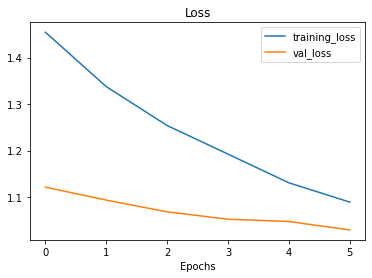

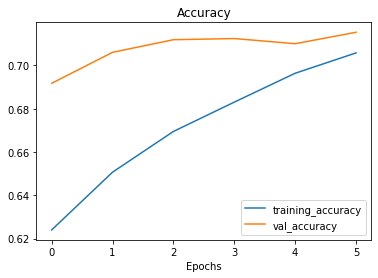

In [52]:
plot_loss_curves(history_5_101_foods_all_augmented)

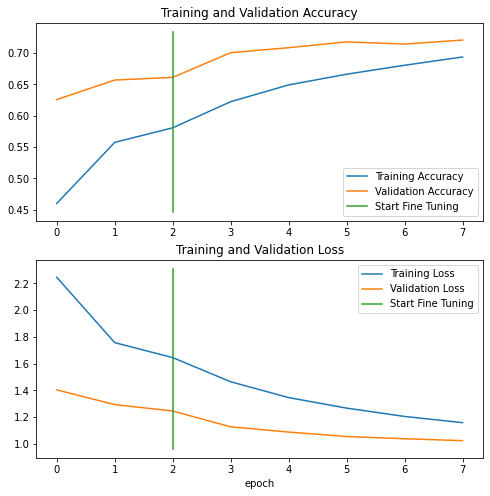

In [53]:
compare_historys(history_2_101_foods_all_augmented,history_5_101_foods_all_augmented, initial_epochs=3)

In [50]:
# Save the model
model_5_aug_fine_tuned.save("model_101_foods_augmented_model_10t_Layers")

# Colab commands to download the model
!zip -r /content/model_tuned_10L.zip /content/model_101_foods_augmented_model_10t_Layers
!zip -r /content/training_log_aug.zip /content/training_log_aug


# Download the file 
from google.colab import files
files.download("/content/model_tuned_10L.zip")
files.download("/content/training_log_aug.zip")

INFO:tensorflow:Assets written to: model_101_foods_augmented_model_10t_Layers/assets


INFO:tensorflow:Assets written to: model_101_foods_augmented_model_10t_Layers/assets


  adding: content/model_101_foods_augmented_model_10t_Layers/ (stored 0%)
  adding: content/model_101_foods_augmented_model_10t_Layers/assets/ (stored 0%)
  adding: content/model_101_foods_augmented_model_10t_Layers/saved_model.pb (deflated 91%)
  adding: content/model_101_foods_augmented_model_10t_Layers/variables/ (stored 0%)
  adding: content/model_101_foods_augmented_model_10t_Layers/variables/variables.index (deflated 74%)
  adding: content/model_101_foods_augmented_model_10t_Layers/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/model_101_foods_augmented_model_10t_Layers/keras_metadata.pb (deflated 96%)
  adding: content/training_log_aug/ (stored 0%)
  adding: content/training_log_aug/efficientnetb0_101_classes_all_data_augmented_fine_tuned/ (stored 0%)
  adding: content/training_log_aug/efficientnetb0_101_classes_all_data_augmented_fine_tuned/20220508-153022/ (stored 0%)
  adding: content/training_log_aug/efficientnetb0_101_classes_all_data_augmented_fine

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Upload the logs on tensorboard and visualize the progress

In [102]:
!tensorboard dev upload --logdir /content/training_log_aug \
--name "Transfer Learning Experiment with 101 Food Types" \
--description "A series of different transfer learning experiments with data augmentation and fine-tuning" \
--one_shot 


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/TQ3oMo3YTamvnryGxVpOSw/

[2022-05-08T16:58:42] Started scanning logdir.
[2022-05-08T16:58:46] Total uploaded: 108 scalars, 0 tensors, 4 binary objects (3.6 MB)
[2022-05-08T16:58:46] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/TQ3oMo3YTamvnryGxVpOSw/
